In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1. Load data and inspect

In [2]:
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.shape

(9742, 3)

In [6]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
df_movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [9]:
df_movies = df_movies.drop(columns="genres")

In [5]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [10]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [11]:
df_ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [13]:
df_ratings = df_ratings.drop(columns="timestamp")

# 2. Merge datasets

In [14]:
df = df_movies.merge(df_ratings, how="left", on="movieId")

Generate no of ratings for each movie

In [18]:
df_no_of_ratings = (df_ratings
                    .groupby("movieId")
                    .count()[["userId"]]
                    .rename(columns={"userId": "no_of_ratings"})
                    .reset_index())

In [20]:
df = df.merge(df_no_of_ratings, how="left", on="movieId")

In [23]:
df

,movieId,title,userId,rating,no_of_ratings
0,1,Toy Story (1995),1.0,4.0,215.0
1,1,Toy Story (1995),5.0,4.0,215.0
2,1,Toy Story (1995),7.0,4.5,215.0
3,1,Toy Story (1995),15.0,2.5,215.0
4,1,Toy Story (1995),17.0,4.5,215.0
...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),184.0,4.0,1.0
100850,193583,No Game No Life: Zero (2017),184.0,3.5,1.0
100851,193585,Flint (2017),184.0,3.5,1.0
100852,193587,Bungo Stray Dogs: Dead Apple (2018),184.0,3.5,1.0


# 2.2. Plot distribution of no_of_reviews

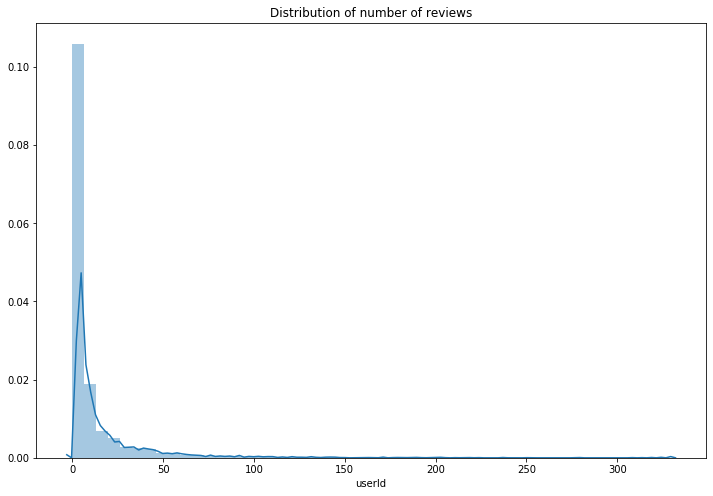

In [26]:
fig = plt.figure(figsize=(12,8))
sns.distplot(df.groupby("movieId").count()["userId"]);
plt.title("Distribution of number of reviews");

In [27]:
df.groupby("movieId").count()["userId"].describe()

count    9742.000000
mean       10.350647
std        22.384729
min         0.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: userId, dtype: float64

Set lower threshold for no_of_ratings to be considered for recommendations

In [28]:
min_no_of_ratings = 10
movies = df[df["no_of_ratings"] >= min_no_of_ratings]

In [29]:
movies.describe()

,movieId,userId,rating,no_of_ratings
count,81116.000000,81116.000000,81116.000000,81116.000000
mean,14857.178078,318.989977,3.573678,71.959589
std,29539.336412,181.748877,1.018590,62.291572
min,1.000000,1.000000,0.500000,10.000000
25%,1007.000000,167.000000,3.000000,26.000000
50%,2471.000000,316.000000,4.000000,51.000000
75%,6016.000000,474.000000,4.000000,99.000000
max,187593.000000,610.000000,5.000000,329.000000


# 3. Modelling

In [33]:
from scipy.sparse import csr_matrix

In [34]:
movie_features = movies.pivot_table(index="movieId",
                                    columns="userId",
                                    values="rating").fillna(0)

In [35]:
mat_movie_features = csr_matrix(movie_features)

In [39]:
mat_movie_features

<2269x610 sparse matrix of type '<class 'numpy.float64'>'
	with 81116 stored elements in Compressed Sparse Row format>

## 3.1. Train KNN

In [40]:
from sklearn.neighbors import NearestNeighbors

In [42]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [51]:
movie_list = movies[["movieId", "title"]].drop_duplicates().set_index("movieId")

In [88]:
movie_id = 248
movie_list.loc[movie_id]

title    Houseguest (1994)
Name: 248, dtype: object

In [89]:
movie_vector = movie_features.loc[movie_id].values.reshape(1, -1)

In [90]:
distances, indices = model_knn.kneighbors(movie_vector, n_neighbors=6)

In [91]:
indices

array([[124, 203, 139,  88, 214, 246]])

In [92]:
distances

array([[0.        , 0.492826  , 0.51832779, 0.5368109 , 0.56231902,
        0.58622932]])

In [93]:
movie_list.iloc[178,].values[0]

'Forrest Gump (1994)'

In [81]:
indices.flatten()

array([   0, 1104,  229,  323,  131,  178])

In [83]:
list(zip(indices.flatten(), distances.flatten()))

[(0, 0.0),
 (1104, 0.4273987396802844),
 (229, 0.4343631959138433),
 (323, 0.43573830647233425),
 (131, 0.4426118294200634),
 (178, 0.4529040920598262)]

In [94]:
recommendations = list(zip(indices.flatten(), distances.flatten()))
for i in range(0,len(indices.flatten())):
    movie_id, dist = recommendations[i]
    if i == 0:
        print(f"Recommendations for {movie_list.iloc[movie_id,].values[0]}:\n")
        print("--------------------------\n")
    else:
        print(f"{i}: {movie_list.iloc[movie_id,].values[0]}, with distance {dist}")

Recommendations for Houseguest (1994):

--------------------------

1: Another Stakeout (1993), with distance 0.49282599813792316
2: Milk Money (1994), with distance 0.5183277859089118
3: Jury Duty (1995), with distance 0.5368108980727805
4: Coneheads (1993), with distance 0.5623190188021755
5: Renaissance Man (1994), with distance 0.5862293193042172


# 4. Recommendations based on title

In [97]:
movie_list.to_dict()["title"]

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 34: 'Babe (1995)',
 36: 'Dead Man Walking (1995)',
 39: 'Clueless (1995)',
 41: 'Richard III (1995)',
 44: 'Mortal Kombat (1995)',
 45: 'To Die For (1995)',
 46: '

In [98]:
movie_index = {movie: i for i, movie in movie_list.to_dict()["title"].items()}

In [99]:
movie_index

{'Toy Story (1995)': 1,
 'Jumanji (1995)': 2,
 'Grumpier Old Men (1995)': 3,
 'Father of the Bride Part II (1995)': 5,
 'Heat (1995)': 6,
 'Sabrina (1995)': 7,
 'Sudden Death (1995)': 9,
 'GoldenEye (1995)': 10,
 'American President, The (1995)': 11,
 'Dracula: Dead and Loving It (1995)': 12,
 'Nixon (1995)': 14,
 'Cutthroat Island (1995)': 15,
 'Casino (1995)': 16,
 'Sense and Sensibility (1995)': 17,
 'Four Rooms (1995)': 18,
 'Ace Ventura: When Nature Calls (1995)': 19,
 'Money Train (1995)': 20,
 'Get Shorty (1995)': 21,
 'Copycat (1995)': 22,
 'Assassins (1995)': 23,
 'Powder (1995)': 24,
 'Leaving Las Vegas (1995)': 25,
 'Othello (1995)': 26,
 'Persuasion (1995)': 28,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 29,
 'Dangerous Minds (1995)': 31,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 32,
 'Babe (1995)': 34,
 'Dead Man Walking (1995)': 36,
 'Clueless (1995)': 39,
 'Richard III (1995)': 41,
 'Mortal Kombat (1995)': 44,
 'To Die For (1995)': 45,
 'How 

### Quick intro to fuzzy string matching

In [101]:
from fuzzywuzzy import fuzz

In [102]:
fuzz.ratio("Hello", "Hello")

100

In [103]:
fuzz.ratio("Hello", "Hillo")

80

In [104]:
fuzz.ratio("Father of the Bride Part II (1995)", "father of bride")

53

In [105]:
fuzz.ratio("Matrix", "Toy Story")

27

----

In [107]:
import re

In [106]:
fav_movie = "Toy Stry"

In [108]:
matched = []
for title, index in movie_index.items():
    extr_title = re.findall(r"(.*) \(\d{4}\)$", title)[0]
    ratio = fuzz.ratio(extr_title.lower(), fav_movie.lower())
    if ratio >= 60:
        matched.append((title, index, ratio))

In [109]:
matched

[('Toy Story (1995)', 1, 94),
 ('Toys (1992)', 2253, 67),
 ('Pet Sematary (1989)', 2513, 60),
 ('Toy Story 2 (1999)', 3114, 84),
 ('Toy Story 3 (2010)', 78499, 84)]

In [114]:
sorted(matched, key=lambda x: x[2], reverse=True)[0][1]

1

# 5. Build our little movie recommender

In [115]:
def find_movie_id(movie_title):
    matched = []
    for title, index in movie_index.items():
        extr_title = re.findall(r"(.*) \(\d{4}\)$", title)[0]
        ratio = fuzz.ratio(extr_title.lower(), movie_title.lower())
        if ratio >= 60:
            matched.append((title, index, ratio))
            
    best_match = sorted(matched, key=lambda x: x[2], reverse=True)[0][1]
    return best_match

In [120]:
find_movie_id("Forrrest Gump")

356

In [121]:
movie_list.loc[356]

title    Forrest Gump (1994)
Name: 356, dtype: object

In [126]:
def recommend_movies(movie_title, n_recommendations=5):
    # find movieId from movie_title
    movie_id = find_movie_id(movie_title)
    
    # find nearest neighbors
    movie_vector = movie_features.loc[movie_id].values.reshape(1, -1)
    distances, indices = model_knn.kneighbors(movie_vector, n_neighbors=n_recommendations+1)
        
    # lookup recommendations
    recommendations = list(zip(indices.flatten(), distances.flatten()))
    for i in range(0,len(indices.flatten())):
        mid, dist = recommendations[i]
        if i == 0:
            print(f"Recommendations for {movie_list.iloc[mid,].values[0]}:\n")
            print("--------------------------\n")
        else:
            print(f"{i}: {movie_list.iloc[mid,].values[0]}, with distance {dist}")

In [124]:
recommend_movies("Inception", 4)

Recommendations for Inception (2010):

--------------------------

1: Dark Knight, The (2008), with distance 0.27273692797625093
2: Inglourious Basterds (2009), with distance 0.35389678083836207
3: Shutter Island (2010), with distance 0.38226361086909444
4: Dark Knight Rises, The (2012), with distance 0.3824955344787052


In [127]:
recommend_movies("the room")

Recommendations for In the Bedroom (2001):

--------------------------

1: Salton Sea, The (2002), with distance 0.4795931372083613
2: Limey, The (1999), with distance 0.4812741472944556
3: Nine to Five (a.k.a. 9 to 5) (1980), with distance 0.5176990035790633
4: Midnight Cowboy (1969), with distance 0.5303919770008494
5: Good Girl, The (2002), with distance 0.5316043117407637


In [128]:
recommend_movies("Room, The")

Recommendations for Rookie, The (2002):

--------------------------

1: John Q (2002), with distance 0.34015619451183043
2: Sum of All Fears, The (2002), with distance 0.3769613337748534
3: Seabiscuit (2003), with distance 0.4045276675581968
4: Miracle (2004), with distance 0.42436311849964325
5: Remember the Titans (2000), with distance 0.458743418346255


In [129]:
recommend_movies("Pulp Fiction")

Recommendations for Pulp Fiction (1994):

--------------------------

1: Silence of the Lambs, The (1991), with distance 0.2906176295563828
2: Shawshank Redemption, The (1994), with distance 0.2976337826022786
3: Seven (a.k.a. Se7en) (1995), with distance 0.3023463819521529
4: Forrest Gump (1994), with distance 0.3144563273687092
5: Usual Suspects, The (1995), with distance 0.3273840967732101


In [130]:
recommend_movies("fight club")

Recommendations for Fight Club (1999):

--------------------------

1: Matrix, The (1999), with distance 0.2860625732802825
2: Memento (2000), with distance 0.33040704494686746
3: American History X (1998), with distance 0.35094583748199937
4: Kill Bill: Vol. 1 (2003), with distance 0.3602624134566229
5: Lord of the Rings: The Fellowship of the Ring, The (2001), with distance 0.36425580638414523


In [131]:
recommend_movies("Akira")

Recommendations for Akira (1988):

--------------------------

1: Ghost in the Shell (Kôkaku kidôtai) (1995), with distance 0.2601008262380423
2: Dark City (1998), with distance 0.45014943140879204
3: Princess Mononoke (Mononoke-hime) (1997), with distance 0.4581015522126558
4: Cowboy Bebop: The Movie (Cowboy Bebop: Tengoku no Tobira) (2001), with distance 0.4785979522580418
5: Brazil (1985), with distance 0.4797706220748491
